In [1]:
# Install the library first (only once needed)
!pip install google-play-scraper

# Now the code
from google_play_scraper import Sort, reviews
import pandas as pd

# Target app
app_package_name = 'com.calm.android'  # Calm app's package name on Google Play

# Scrape reviews
result, _ = reviews(
    app_package_name,
    lang='en',         # Language
    country='us',      # Country
    sort=Sort.NEWEST,  # Sort by newest first
    count=1000,        # Number of reviews you want to scrape
    filter_score_with=None  # Get all reviews, not just positive/negative
)

# Convert to DataFrame
df = pd.DataFrame(result)

# Select only important columns
df = df[['reviewId', 'userName', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at']]

# Rename for better clarity
df.columns = ['Review ID', 'User Name', 'Review Content', 'Rating', 'Helpful Count', 'App Version', 'Review Date']

# Save to CSV
df.to_csv('calm_reviews.csv', index=False)

print(f"Scraped {len(df)} reviews and saved to 'calm_reviews.csv'.")


Scraped 1000 reviews and saved to 'calm_reviews.csv'.


In [2]:
# Install transformers if not installed
!pip install transformers

# Import libraries
import pandas as pd
from transformers import pipeline

# Load Calm Reviews
df = pd.read_csv('calm_reviews.csv')

# Load sentiment analysis pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

# Predict sentiments
predictions = sentiment_pipeline(list(df['Review Content']), batch_size=16)

# Add raw model predictions
df['Predicted Sentiment Label'] = [pred['label'] for pred in predictions]
df['Predicted Sentiment Score'] = [pred['score'] for pred in predictions]

# Define a function to map confidence scores to Neutral if low confidence
def classify_with_neutral(label, score, threshold=0.7):
    if score >= threshold:
        return label
    else:
        return 'Neutral'

# Apply the function
df['Final Sentiment'] = [
    classify_with_neutral(label, score)
    for label, score in zip(df['Predicted Sentiment Label'], df['Predicted Sentiment Score'])
]

# Save the updated DataFrame
df.to_csv('calm_reviews_with_true_sentiment_and_neutral.csv', index=False)

print("✅ Sentiment Analysis with Neutral handling complete!")
print("✅ File saved as 'calm_reviews_with_true_sentiment_and_neutral.csv'.")



✅ Sentiment Analysis with Neutral handling complete!
✅ File saved as 'calm_reviews_with_true_sentiment_and_neutral.csv'.


In [3]:
# --- Install packages if not installed ---
# pip install openai pandas tqdm

import pandas as pd
import openai
from tqdm import tqdm
import os
import time
from datetime import datetime

# --- Step 1: Configure Groq API ---
openai.api_key = "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"  # <<< Replace with your Groq API Key
openai.base_url = "https://api.groq.com/openai/v1/"  # ✅ Important: Trailing slash /

# --- Choose the Model ---
model_name = "llama3-8b-8192"  # Or you can use "mixtral-8x7b-32768" for faster response

# --- Step 2: Load Your CSV File ---
input_file = "calm_reviews_with_true_sentiment_and_neutral.csv"
df_full = pd.read_csv(input_file)

# Check if 'Review Content' column exists
if 'Review Content' not in df_full.columns:
    raise ValueError("The CSV file must contain a column named 'Review Content'.")

# --- Step 3: Setup Log Files ---
success_log_file = "success_log.txt"
error_log_file = "error_log.txt"

def write_log(file_path, message):
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(file_path, "a", encoding="utf-8") as f:
        f.write(f"[{timestamp}] {message}\n")

# --- Step 4: Check for Intermediate Progress ---
intermediate_file = "intermediate_progress_calm_reviews.csv"
if os.path.exists(intermediate_file):
    print(f"📂 Found intermediate file. Resuming from {intermediate_file}...")
    df_intermediate = pd.read_csv(intermediate_file)
    completed_reviews = len(df_intermediate)
    summarized_reviews = df_intermediate['Summary'].tolist()
else:
    print("📂 No intermediate file found. Starting fresh...")
    completed_reviews = 0
    summarized_reviews = []

# --- Step 5: Initialize Counters ---
success_count = 0
failure_count = 0

# --- Step 6: Summarize Remaining Reviews (with logging and auto-save) ---
for idx in tqdm(range(completed_reviews, len(df_full)), desc="Summarizing Reviews", unit="review"):
    review = df_full.loc[idx, 'Review Content']

    if pd.isna(review) or review.strip() == "":
        summarized_reviews.append("")
        write_log(success_log_file, f"✅ Review {idx+1}: Empty review skipped.")
        success_count += 1
        continue

    try:
        response = openai.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are a professional summarizer. Keep tone natural and match the review's sentiment (positive, neutral, negative)."},
                {"role": "user", "content": f"Summarize the following Calm app review in 1–2 short sentences, accurately reflecting the user's real experience and emotional tone. Avoid exaggeration. Be realistic and concise.\n\nReview:\n{review.strip()}"}
            ],
            temperature=0.2,
            max_tokens=150
        )
        summary_text = response.choices[0].message.content.strip()
        summarized_reviews.append(summary_text)
        write_log(success_log_file, f"✅ Review {idx+1}: Successfully summarized.")
        success_count += 1
        time.sleep(1)  # Sleep a little to avoid hammering the API

    except Exception as e:
        error_message = str(e)
        summarized_reviews.append("Summarization failed.")
        write_log(error_log_file, f"❌ Review {idx+1}: Summarization failed. Error: {error_message}")
        print(f"⚠️ Summarization failed for review {idx}: {error_message}")
        print("🕑 Waiting extra 30 seconds to avoid further failures...")
        failure_count += 1
        time.sleep(30)  # Sleep longer after failure

    # --- Save progress after every 10 reviews ---
    if (idx + 1) % 10 == 0 or (idx + 1) == len(df_full):
        temp_df = df_full.iloc[:len(summarized_reviews)].copy()
        temp_df['Summary'] = summarized_reviews  # ✅ Column renamed here
        temp_df.to_csv(intermediate_file, index=False)
        print(f"💾 Auto-saved after {idx+1} reviews.")

# --- Step 7: Final Save ---
df_full['Summary'] = summarized_reviews  # ✅ Column renamed here
final_output = "summarized_calm_reviews_groq.csv"
df_full.to_csv(final_output, index=False)

print(f"✅ Summarization complete. Final results saved to {final_output}.")

# --- Step 8: Cleanup
if os.path.exists(intermediate_file):
    print(f"🧹 Cleaning up intermediate file...")
    os.remove(intermediate_file)

# --- Step 9: Write Final Summary Report
summary_report = f"""
🏁 SUMMARY REPORT:
Total reviews processed: {len(df_full)}
Successful summarizations: {success_count}
Failed summarizations: {failure_count}
"""

print(summary_report)

# Save summary to a file
with open("summary_report.txt", "w", encoding="utf-8") as f:
    f.write(summary_report.strip())

print("📄 Summary report saved to 'summary_report.txt'.")

📂 No intermediate file found. Starting fresh...


Summarizing Reviews:   1%|          | 10/1000 [00:14<20:46,  1.26s/review]

💾 Auto-saved after 10 reviews.


Summarizing Reviews:   2%|▏         | 20/1000 [00:27<20:37,  1.26s/review]

💾 Auto-saved after 20 reviews.


Summarizing Reviews:   3%|▎         | 30/1000 [00:39<20:17,  1.26s/review]

💾 Auto-saved after 30 reviews.


Summarizing Reviews:   4%|▍         | 40/1000 [01:02<37:47,  2.36s/review]

💾 Auto-saved after 40 reviews.


Summarizing Reviews:   5%|▌         | 50/1000 [01:27<39:23,  2.49s/review]

💾 Auto-saved after 50 reviews.


Summarizing Reviews:   6%|▌         | 60/1000 [01:51<37:51,  2.42s/review]

💾 Auto-saved after 60 reviews.


Summarizing Reviews:   7%|▋         | 70/1000 [02:31<34:26,  2.22s/review]  

💾 Auto-saved after 70 reviews.


Summarizing Reviews:   8%|▊         | 80/1000 [02:45<21:31,  1.40s/review]

💾 Auto-saved after 80 reviews.


Summarizing Reviews:   9%|▉         | 90/1000 [02:59<20:50,  1.37s/review]

💾 Auto-saved after 90 reviews.


Summarizing Reviews:  10%|█         | 100/1000 [03:19<34:28,  2.30s/review]

💾 Auto-saved after 100 reviews.


Summarizing Reviews:  11%|█         | 110/1000 [03:44<36:21,  2.45s/review]

💾 Auto-saved after 110 reviews.


Summarizing Reviews:  12%|█▏        | 120/1000 [04:09<36:41,  2.50s/review]

💾 Auto-saved after 120 reviews.


Summarizing Reviews:  13%|█▎        | 130/1000 [04:34<36:13,  2.50s/review]

💾 Auto-saved after 130 reviews.


Summarizing Reviews:  14%|█▍        | 140/1000 [04:59<35:25,  2.47s/review]

💾 Auto-saved after 140 reviews.


Summarizing Reviews:  15%|█▌        | 150/1000 [05:23<34:33,  2.44s/review]

💾 Auto-saved after 150 reviews.


Summarizing Reviews:  16%|█▌        | 160/1000 [05:48<34:35,  2.47s/review]

💾 Auto-saved after 160 reviews.


Summarizing Reviews:  17%|█▋        | 170/1000 [06:12<34:05,  2.46s/review]

💾 Auto-saved after 170 reviews.


Summarizing Reviews:  18%|█▊        | 180/1000 [06:36<32:36,  2.39s/review]

💾 Auto-saved after 180 reviews.


Summarizing Reviews:  19%|█▉        | 190/1000 [07:01<32:31,  2.41s/review]

💾 Auto-saved after 190 reviews.


Summarizing Reviews:  20%|██        | 200/1000 [07:25<33:19,  2.50s/review]

💾 Auto-saved after 200 reviews.


Summarizing Reviews:  21%|██        | 210/1000 [07:50<32:26,  2.46s/review]

💾 Auto-saved after 210 reviews.


Summarizing Reviews:  22%|██▏       | 220/1000 [08:15<32:06,  2.47s/review]

💾 Auto-saved after 220 reviews.


Summarizing Reviews:  23%|██▎       | 230/1000 [08:40<31:45,  2.47s/review]

💾 Auto-saved after 230 reviews.


Summarizing Reviews:  24%|██▍       | 240/1000 [09:05<31:36,  2.50s/review]

💾 Auto-saved after 240 reviews.


Summarizing Reviews:  25%|██▌       | 250/1000 [09:30<30:55,  2.47s/review]

💾 Auto-saved after 250 reviews.


Summarizing Reviews:  26%|██▌       | 260/1000 [09:55<31:20,  2.54s/review]

💾 Auto-saved after 260 reviews.


Summarizing Reviews:  27%|██▋       | 270/1000 [10:21<31:41,  2.60s/review]

💾 Auto-saved after 270 reviews.


Summarizing Reviews:  28%|██▊       | 280/1000 [10:46<30:00,  2.50s/review]

💾 Auto-saved after 280 reviews.


Summarizing Reviews:  29%|██▉       | 290/1000 [11:11<29:34,  2.50s/review]

💾 Auto-saved after 290 reviews.


Summarizing Reviews:  30%|███       | 300/1000 [11:36<30:02,  2.58s/review]

💾 Auto-saved after 300 reviews.


Summarizing Reviews:  31%|███       | 310/1000 [12:01<27:39,  2.40s/review]

💾 Auto-saved after 310 reviews.


Summarizing Reviews:  32%|███▏      | 320/1000 [12:26<28:43,  2.54s/review]

💾 Auto-saved after 320 reviews.


Summarizing Reviews:  33%|███▎      | 330/1000 [12:51<27:38,  2.47s/review]

💾 Auto-saved after 330 reviews.


Summarizing Reviews:  34%|███▍      | 340/1000 [13:16<26:38,  2.42s/review]

💾 Auto-saved after 340 reviews.


Summarizing Reviews:  35%|███▌      | 350/1000 [13:40<26:28,  2.44s/review]

💾 Auto-saved after 350 reviews.


Summarizing Reviews:  36%|███▌      | 360/1000 [14:05<26:10,  2.45s/review]

💾 Auto-saved after 360 reviews.


Summarizing Reviews:  37%|███▋      | 370/1000 [14:29<26:20,  2.51s/review]

💾 Auto-saved after 370 reviews.


Summarizing Reviews:  38%|███▊      | 380/1000 [14:54<26:14,  2.54s/review]

💾 Auto-saved after 380 reviews.


Summarizing Reviews:  39%|███▉      | 390/1000 [15:19<25:33,  2.51s/review]

💾 Auto-saved after 390 reviews.


Summarizing Reviews:  40%|████      | 400/1000 [15:44<25:16,  2.53s/review]

💾 Auto-saved after 400 reviews.


Summarizing Reviews:  41%|████      | 410/1000 [16:09<24:36,  2.50s/review]

💾 Auto-saved after 410 reviews.


Summarizing Reviews:  42%|████▏     | 420/1000 [16:34<23:53,  2.47s/review]

💾 Auto-saved after 420 reviews.


Summarizing Reviews:  43%|████▎     | 430/1000 [16:58<22:58,  2.42s/review]

💾 Auto-saved after 430 reviews.


Summarizing Reviews:  44%|████▍     | 440/1000 [17:23<22:24,  2.40s/review]

💾 Auto-saved after 440 reviews.


Summarizing Reviews:  45%|████▌     | 450/1000 [17:49<23:33,  2.57s/review]

💾 Auto-saved after 450 reviews.


Summarizing Reviews:  46%|████▌     | 460/1000 [18:14<21:47,  2.42s/review]

💾 Auto-saved after 460 reviews.


Summarizing Reviews:  47%|████▋     | 470/1000 [18:39<22:22,  2.53s/review]

💾 Auto-saved after 470 reviews.


Summarizing Reviews:  48%|████▊     | 480/1000 [19:04<21:38,  2.50s/review]

💾 Auto-saved after 480 reviews.


Summarizing Reviews:  49%|████▉     | 490/1000 [19:30<21:26,  2.52s/review]

💾 Auto-saved after 490 reviews.


Summarizing Reviews:  50%|█████     | 500/1000 [19:55<21:07,  2.54s/review]

💾 Auto-saved after 500 reviews.


Summarizing Reviews:  51%|█████     | 507/1000 [29:28<23:09:56, 169.16s/review]

⚠️ Summarization failed for review 507: Connection error.
🕑 Waiting extra 30 seconds to avoid further failures...


Summarizing Reviews:  51%|█████     | 510/1000 [30:03<8:37:45, 63.40s/review]  

💾 Auto-saved after 510 reviews.


Summarizing Reviews:  52%|█████▏    | 520/1000 [30:17<26:06,  3.26s/review]  

💾 Auto-saved after 520 reviews.


Summarizing Reviews:  52%|█████▎    | 525/1000 [30:31<27:27,  3.47s/review]

⚠️ Summarization failed for review 525: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01jsttgpype479s787xtfwzhst` service tier `on_demand` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.729s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'requests', 'code': 'rate_limit_exceeded'}}
🕑 Waiting extra 30 seconds to avoid further failures...


Summarizing Reviews:  53%|█████▎    | 530/1000 [31:09<31:10,  3.98s/review]  

💾 Auto-saved after 530 reviews.


Summarizing Reviews:  54%|█████▍    | 540/1000 [31:27<13:57,  1.82s/review]

💾 Auto-saved after 540 reviews.


Summarizing Reviews:  55%|█████▌    | 550/1000 [31:41<09:48,  1.31s/review]

💾 Auto-saved after 550 reviews.


Summarizing Reviews:  56%|█████▌    | 560/1000 [31:56<12:26,  1.70s/review]

💾 Auto-saved after 560 reviews.


Summarizing Reviews:  57%|█████▋    | 570/1000 [32:23<17:35,  2.45s/review]

💾 Auto-saved after 570 reviews.


Summarizing Reviews:  58%|█████▊    | 580/1000 [32:48<17:25,  2.49s/review]

💾 Auto-saved after 580 reviews.


Summarizing Reviews:  59%|█████▉    | 590/1000 [33:12<16:26,  2.41s/review]

💾 Auto-saved after 590 reviews.


Summarizing Reviews:  60%|██████    | 600/1000 [33:36<16:22,  2.46s/review]

💾 Auto-saved after 600 reviews.


Summarizing Reviews:  61%|██████    | 610/1000 [34:01<16:22,  2.52s/review]

💾 Auto-saved after 610 reviews.


Summarizing Reviews:  62%|██████▏   | 620/1000 [34:26<15:37,  2.47s/review]

💾 Auto-saved after 620 reviews.


Summarizing Reviews:  63%|██████▎   | 630/1000 [34:50<14:58,  2.43s/review]

💾 Auto-saved after 630 reviews.


Summarizing Reviews:  64%|██████▍   | 640/1000 [35:14<15:13,  2.54s/review]

💾 Auto-saved after 640 reviews.


Summarizing Reviews:  65%|██████▌   | 650/1000 [35:40<14:45,  2.53s/review]

💾 Auto-saved after 650 reviews.


Summarizing Reviews:  66%|██████▌   | 660/1000 [36:05<14:51,  2.62s/review]

💾 Auto-saved after 660 reviews.


Summarizing Reviews:  67%|██████▋   | 670/1000 [36:30<13:08,  2.39s/review]

💾 Auto-saved after 670 reviews.


Summarizing Reviews:  68%|██████▊   | 676/1000 [36:45<13:47,  2.55s/review]

⚠️ Summarization failed for review 676: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01jsttgpype479s787xtfwzhst` service tier `on_demand` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.823s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'requests', 'code': 'rate_limit_exceeded'}}
🕑 Waiting extra 30 seconds to avoid further failures...


Summarizing Reviews:  68%|██████▊   | 680/1000 [37:24<26:51,  5.04s/review]  

💾 Auto-saved after 680 reviews.


Summarizing Reviews:  69%|██████▉   | 690/1000 [37:37<07:25,  1.44s/review]

💾 Auto-saved after 690 reviews.


Summarizing Reviews:  70%|███████   | 700/1000 [37:59<11:54,  2.38s/review]

💾 Auto-saved after 700 reviews.


Summarizing Reviews:  71%|███████   | 710/1000 [38:24<11:44,  2.43s/review]

💾 Auto-saved after 710 reviews.


Summarizing Reviews:  72%|███████▏  | 720/1000 [38:48<11:28,  2.46s/review]

💾 Auto-saved after 720 reviews.


Summarizing Reviews:  73%|███████▎  | 730/1000 [39:13<11:28,  2.55s/review]

💾 Auto-saved after 730 reviews.


Summarizing Reviews:  74%|███████▍  | 740/1000 [39:38<10:33,  2.44s/review]

💾 Auto-saved after 740 reviews.


Summarizing Reviews:  75%|███████▌  | 750/1000 [40:03<10:35,  2.54s/review]

💾 Auto-saved after 750 reviews.


Summarizing Reviews:  76%|███████▌  | 760/1000 [40:39<07:25,  1.86s/review]

💾 Auto-saved after 760 reviews.


Summarizing Reviews:  77%|███████▋  | 770/1000 [41:01<09:21,  2.44s/review]

💾 Auto-saved after 770 reviews.


Summarizing Reviews:  78%|███████▊  | 780/1000 [41:25<08:58,  2.45s/review]

💾 Auto-saved after 780 reviews.


Summarizing Reviews:  79%|███████▉  | 790/1000 [41:50<08:40,  2.48s/review]

💾 Auto-saved after 790 reviews.


Summarizing Reviews:  80%|████████  | 800/1000 [42:16<08:19,  2.50s/review]

💾 Auto-saved after 800 reviews.


Summarizing Reviews:  81%|████████  | 810/1000 [42:40<07:47,  2.46s/review]

💾 Auto-saved after 810 reviews.


Summarizing Reviews:  82%|████████▏ | 820/1000 [43:05<07:23,  2.47s/review]

💾 Auto-saved after 820 reviews.


Summarizing Reviews:  83%|████████▎ | 830/1000 [43:30<07:07,  2.51s/review]

💾 Auto-saved after 830 reviews.


Summarizing Reviews:  84%|████████▍ | 840/1000 [43:55<06:40,  2.51s/review]

💾 Auto-saved after 840 reviews.


Summarizing Reviews:  85%|████████▌ | 850/1000 [44:19<06:11,  2.48s/review]

💾 Auto-saved after 850 reviews.


Summarizing Reviews:  86%|████████▌ | 860/1000 [45:02<03:56,  1.69s/review]

💾 Auto-saved after 860 reviews.


Summarizing Reviews:  87%|████████▋ | 870/1000 [45:20<04:50,  2.24s/review]

💾 Auto-saved after 870 reviews.


Summarizing Reviews:  88%|████████▊ | 880/1000 [45:44<04:48,  2.40s/review]

💾 Auto-saved after 880 reviews.


Summarizing Reviews:  89%|████████▉ | 890/1000 [46:09<04:35,  2.50s/review]

💾 Auto-saved after 890 reviews.


Summarizing Reviews:  90%|█████████ | 900/1000 [46:33<04:05,  2.46s/review]

💾 Auto-saved after 900 reviews.


Summarizing Reviews:  91%|█████████ | 910/1000 [46:58<03:36,  2.40s/review]

💾 Auto-saved after 910 reviews.


Summarizing Reviews:  92%|█████████▏| 920/1000 [47:22<03:14,  2.43s/review]

💾 Auto-saved after 920 reviews.


Summarizing Reviews:  93%|█████████▎| 930/1000 [47:47<02:56,  2.52s/review]

💾 Auto-saved after 930 reviews.


Summarizing Reviews:  94%|█████████▎| 935/1000 [48:00<02:46,  2.57s/review]

⚠️ Summarization failed for review 935: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01jsttgpype479s787xtfwzhst` service tier `on_demand` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.454s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'requests', 'code': 'rate_limit_exceeded'}}
🕑 Waiting extra 30 seconds to avoid further failures...


Summarizing Reviews:  94%|█████████▍| 940/1000 [48:48<05:17,  5.29s/review]

💾 Auto-saved after 940 reviews.


Summarizing Reviews:  95%|█████████▌| 950/1000 [49:13<02:08,  2.56s/review]

💾 Auto-saved after 950 reviews.


Summarizing Reviews:  96%|█████████▌| 960/1000 [49:38<01:40,  2.52s/review]

💾 Auto-saved after 960 reviews.


Summarizing Reviews:  97%|█████████▋| 970/1000 [50:05<01:20,  2.68s/review]

💾 Auto-saved after 970 reviews.


Summarizing Reviews:  98%|█████████▊| 980/1000 [50:35<01:13,  3.67s/review]

💾 Auto-saved after 980 reviews.


Summarizing Reviews:  99%|█████████▉| 990/1000 [51:07<00:26,  2.64s/review]

💾 Auto-saved after 990 reviews.


Summarizing Reviews: 100%|██████████| 1000/1000 [51:34<00:00,  3.09s/review]

💾 Auto-saved after 1000 reviews.
✅ Summarization complete. Final results saved to summarized_calm_reviews_groq.csv.
🧹 Cleaning up intermediate file...

🏁 SUMMARY REPORT:
Total reviews processed: 1000
Successful summarizations: 996
Failed summarizations: 4

📄 Summary report saved to 'summary_report.txt'.


C:\Users\keert\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


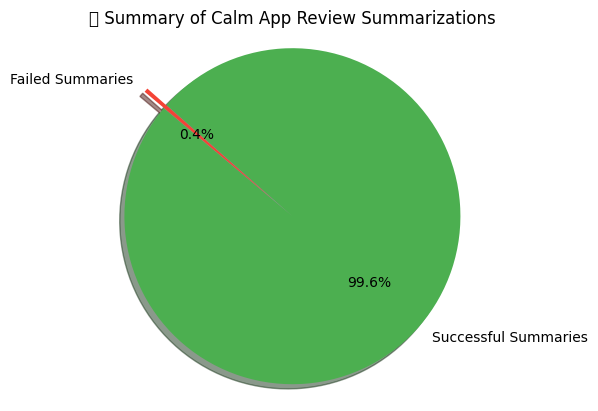

In [4]:
# --- Step 10: Generate Pie Chart for Success vs Failure

import matplotlib.pyplot as plt

# Data for pie chart
labels = ['Successful Summaries', 'Failed Summaries']
sizes = [success_count, failure_count]
colors = ['#4CAF50', '#F44336']  # Green for success, Red for failure
explode = (0.05, 0.1)  # "explode" the slices a little for visibility

# Plot
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors,
       autopct='%1.1f%%', shadow=True, startangle=140)
ax.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle

plt.title('📊 Summary of Calm App Review Summarizations')
plt.show()

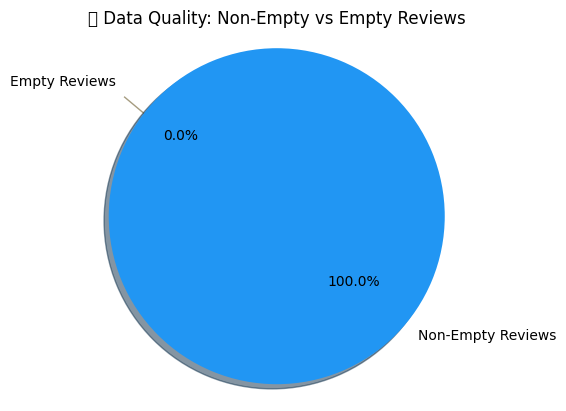

In [5]:
# --- Step 11: Generate Pie Chart for Empty vs Non-Empty Reviews

# Count empty vs non-empty reviews
empty_reviews = df_full['Review Content'].isna().sum() + (df_full['Review Content'].str.strip() == "").sum()
non_empty_reviews = len(df_full) - empty_reviews

# Data for pie chart
labels_empty = ['Non-Empty Reviews', 'Empty Reviews']
sizes_empty = [non_empty_reviews, empty_reviews]
colors_empty = ['#2196F3', '#FFC107']  # Blue for non-empty, Yellow for empty
explode_empty = (0.05, 0.1)

# Plot
fig, ax = plt.subplots()
ax.pie(sizes_empty, explode=explode_empty, labels=labels_empty, colors=colors_empty,
       autopct='%1.1f%%', shadow=True, startangle=140)
ax.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle

plt.title('📊 Data Quality: Non-Empty vs Empty Reviews')
plt.show()

In [6]:
# Install required libraries if not installed
# Uncomment these lines if you don't have these installed
# !pip install pandas
# !pip install groq

import pandas as pd
import groq

# Setup Groq client
groq_client = groq.Groq(api_key="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")  

# Load reviews CSV
df = pd.read_csv('calm_reviews.csv')  # Adjust filename if different

# Check if 'Review Content' column exists
if 'Review Content' not in df.columns:
    raise ValueError("CSV must have a column named 'Review Content'!")

# Create empty columns to store business insights
df['Likes'] = ""
df['Dislikes'] = ""

# Process each review
for idx, review in df['Review Content'].items():
    if pd.isna(review) or review.strip() == "":
        df.at[idx, 'Likes'] = "No review provided."
        df.at[idx, 'Dislikes'] = "No review provided."
        continue

    prompt = f"""
You are a business analyst.

Summarize the following Calm App user review into two very short bullet points:
- What the user liked (under 10 words)
- What the user disliked (under 10 words)

User Review:
{review}

Return the two bullet points clearly, separated by a line break.
"""

    try:
        response = groq_client.chat.completions.create(
            model="llama3-70b-8192",
            messages=[
                {"role": "user", "content": prompt}
            ]
        )
        
        summary_text = response.choices[0].message.content.strip()

        # Split into Likes and Dislikes
        if "Dislikes" in summary_text:
            like_line, dislike_line = summary_text.split("\n", 1)
            df.at[idx, 'Likes'] = like_line.replace("Likes:", "").strip(" -👍👎")
            df.at[idx, 'Dislikes'] = dislike_line.replace("Dislikes:", "").strip(" -👍👎")
        else:
            df.at[idx, 'Likes'] = summary_text
            df.at[idx, 'Dislikes'] = "N/A"

    except Exception as e:
        print(f"Error summarizing review at index {idx}: {e}")
        df.at[idx, 'Likes'] = "Error"
        df.at[idx, 'Dislikes'] = "Error"

# Save the final DataFrame
df.to_csv('calm_reviews_with_likes_dislikes.csv', index=False)

print("✅ Business Insights extracted and saved to 'calm_reviews_with_likes_dislikes.csv'")


Error summarizing review at index 728: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01jsttgpype479s787xtfwzhst` service tier `on_demand` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.912s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'requests', 'code': 'rate_limit_exceeded'}}
Error summarizing review at index 787: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01jsttgpype479s787xtfwzhst` service tier `on_demand` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.765s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'requests', 'code': 'rate_limit_exceeded'}}
Error summarizing review at index 832: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in or

In [7]:
import pandas as pd

# Load your Excel file
df = pd.read_excel('summarized_calm_reviews_groq.xlsx')

# Show first few rows
df.head()


,Review ID,User Name,Review Content,Rating,Helpful Count,App Version,Review Date,Predicted Sentiment Label,Predicted Sentiment Score,Final Sentiment,Summary
0,804ca397-e04a-4214-be56-20e4683ca3a8,Marina Michaels,Perfect sleep solution. I went from being able...,5,0,6.68.1,2025-04-26 13:24:27,NEGATIVE,0.987137,NEGATIVE,Here is a 1-2 sentence summary of the review:\...
1,a14aee39-cbe9-4d27-bf1c-3eb6c5e56182,Sunny L.,"cancelled subscription, got charged next month.",1,0,6.67,2025-04-26 10:44:59,NEGATIVE,0.998231,NEGATIVE,The user had a frustrating experience with the...
2,f06a07d0-54db-4e04-b4e3-995013715237,D. Colbert,PURPOSELY FALSE & MISLEADING ADVERTISING: FAIL...,1,1,NaN,2025-04-26 05:31:27,NEGATIVE,0.999757,NEGATIVE,Here is a 1-2 sentence summary of the review:\...
3,a4e6f76e-d338-4917-a9c6-2021d88edfca,Rob Fann,The only way one can use this is through a pai...,1,0,6.68.1,2025-04-25 23:08:50,NEGATIVE,0.999585,NEGATIVE,Here is a summary of the review in 1-2 short s...
4,75c61fc0-0cf2-4b9c-8783-d7a045f8a594,Ann,waiting to try it tonite,4,0,6.44.3,2025-04-25 22:39:18,NEGATIVE,0.995624,NEGATIVE,The user is looking forward to trying the Calm...


In [8]:
import matplotlib.pyplot as plt

# Group and count Likes
top_likes = df['Likes'].value_counts().head(10)

# Plot
plt.figure(figsize=(10,6))
top_likes.plot(kind='bar', color='skyblue')
plt.title('Top 10 Things Users Liked About Calm App')
plt.xlabel('Likes')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


KeyError: 'Likes'

In [ ]:
# Group and count Dislikes
top_dislikes = df['Dislikes'].value_counts().head(10)

# Plot
plt.figure(figsize=(10,6))
top_dislikes.plot(kind='bar', color='salmon')
plt.title('Top 10 Things Users Disliked About Calm App')
plt.xlabel('Dislikes')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
from wordcloud import WordCloud

# Combine all Likes into a single string
likes_text = " ".join(df['Likes'].dropna().astype(str))

# Generate Word Cloud
wordcloud_likes = WordCloud(width=800, height=400, background_color='white').generate(likes_text)

# Plot
plt.figure(figsize=(10,6))
plt.imshow(wordcloud_likes, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Likes')
plt.show()


In [ ]:
# Combine all Dislikes into a single string
dislikes_text = " ".join(df['Dislikes'].dropna().astype(str))

# Generate Word Cloud
wordcloud_dislikes = WordCloud(width=800, height=400, background_color='white').generate(dislikes_text)

# Plot
plt.figure(figsize=(10,6))
plt.imshow(wordcloud_dislikes, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Dislikes')
plt.show()
